### 图分类任务
- 这回咱们拿到的不是一个图，而是一堆图(188个)
- 对这些图整体进行分类任务，数据集概述如下：

In [1]:
import torch
from torch_geometric.datasets import TUDataset #分子数据集：https://chrsmrrs.github.io/datasets/

dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

D:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
D:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
D:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
  stacklevel=1)



Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [2]:
dataset[3]

Data(edge_index=[2, 44], x=[19, 7], edge_attr=[44, 4], y=[1])

In [3]:
train_dataset = dataset
print(f'Number of training graphs: {len(train_dataset)}')

Number of training graphs: 188


## Mini-batching

- 图也可以进行batch，这个做法与图像和文本数据的batch不太一样
- 这里只是拼接邻接矩阵和数据而已，没有对其做统一操作

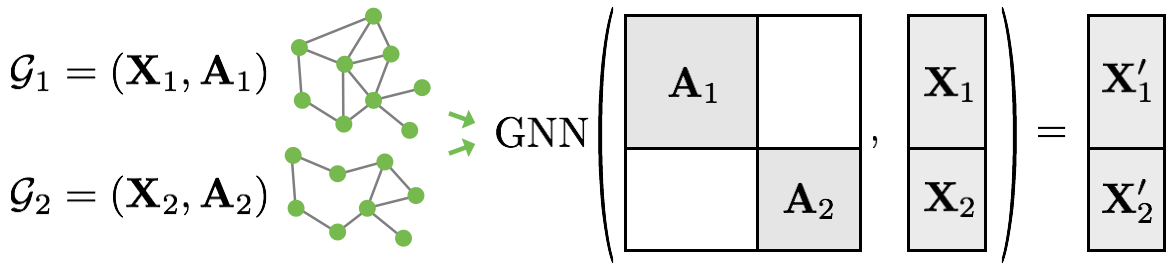

In [4]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2546], x=[1153, 7], edge_attr=[2546, 4], y=[64], batch=[1153], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2376], x=[1085, 7], edge_attr=[2376, 4], y=[64], batch=[1085], ptr=[65])

Step 3:
Number of graphs in the current batch: 60
DataBatch(edge_index=[2, 2520], x=[1133, 7], edge_attr=[2520, 4], y=[60], batch=[1133], ptr=[61])



现在对188个图，做成了3个batch

### 设计网络结构

- 其实还是对各个节点进行特征编码，只不过现在多了一步聚合操作
- 把各个节点特征汇总成全局特征就相当于得到了整个图的编码：[`torch_geometric.nn.global_mean_pool`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.glob.global_mean_pool)
$$
\mathbf{x}_{\mathcal{G}} = \frac{1}{|\mathcal{V}|} \sum_{v \in \mathcal{V}} \mathcal{x}^{(L)}_v
$$


In [5]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1.对各节点进行编码
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. 平均操作
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. 输出
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [6]:
model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 171):
    train()
    train_acc = test(train_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}')

Epoch: 001, Train Acc: 0.6649
Epoch: 002, Train Acc: 0.6649
Epoch: 003, Train Acc: 0.6649
Epoch: 004, Train Acc: 0.6702
Epoch: 005, Train Acc: 0.6809
Epoch: 006, Train Acc: 0.7181
Epoch: 007, Train Acc: 0.7234
Epoch: 008, Train Acc: 0.7234
Epoch: 009, Train Acc: 0.7287
Epoch: 010, Train Acc: 0.7340
Epoch: 011, Train Acc: 0.7340
Epoch: 012, Train Acc: 0.7447
Epoch: 013, Train Acc: 0.7447
Epoch: 014, Train Acc: 0.7394
Epoch: 015, Train Acc: 0.7394
Epoch: 016, Train Acc: 0.7500
Epoch: 017, Train Acc: 0.7394
Epoch: 018, Train Acc: 0.7500
Epoch: 019, Train Acc: 0.7500
Epoch: 020, Train Acc: 0.7394
Epoch: 021, Train Acc: 0.7553
Epoch: 022, Train Acc: 0.7553
Epoch: 023, Train Acc: 0.7660
Epoch: 024, Train Acc: 0.7606
Epoch: 025, Train Acc: 0.7660
Epoch: 026, Train Acc: 0.7660
Epoch: 027, Train Acc: 0.7766
Epoch: 028, Train Acc: 0.7660
Epoch: 029, Train Acc: 0.7660
Epoch: 030, Train Acc: 0.7819
Epoch: 031, Train Acc: 0.7660
Epoch: 032, Train Acc: 0.7660
Epoch: 033, Train Acc: 0.7819
Epoch: 034